In [8]:
import os

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

eda_middle_data_path = 'eda-middle-data/'

res = pd.DataFrame([], columns=['pcode', 'max_amplitude', 'scr_count_per_minute'])
measurement = 'scr_count_per_minute'

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = eda_middle_data_path + participant_key + '_eda_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist.')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 3:
        print(file_path + ' has too less data, filtered out')
        continue
        
    res.loc[len(res)] = [participant_key, df['max_amplitude'].mean(), df['scr_count_per_minute'].mean()]

res

eda-middle-data/P01_eda_result.csv do not exist.
eda-middle-data/P04_eda_result.csv has too less data, filtered out
eda-middle-data/P07_eda_result.csv do not exist.
eda-middle-data/P08_eda_result.csv has too less data, filtered out
eda-middle-data/P10_eda_result.csv has too less data, filtered out
eda-middle-data/P20_eda_result.csv has too less data, filtered out
eda-middle-data/P27_eda_result.csv do not exist.
eda-middle-data/P29_eda_result.csv has too less data, filtered out
eda-middle-data/P42_eda_result.csv has too less data, filtered out
eda-middle-data/P44_eda_result.csv has too less data, filtered out
eda-middle-data/P48_eda_result.csv has too less data, filtered out
eda-middle-data/P49_eda_result.csv has too less data, filtered out
eda-middle-data/P56_eda_result.csv has too less data, filtered out
eda-middle-data/P58_eda_result.csv has too less data, filtered out
eda-middle-data/P59_eda_result.csv do not exist.
eda-middle-data/P65_eda_result.csv do not exist.
eda-middle-data/P7

,pcode,max_amplitude,scr_count_per_minute
0,P02,0.470150,2.494056
1,P03,0.110518,1.668148
2,P05,0.302162,2.528684
3,P06,0.486098,2.996583
4,P09,0.146379,1.631947
5,P11,0.151112,3.496175
6,P12,0.220381,2.343796
7,P13,0.607574,2.505379
8,P14,0.120298,3.049609
9,P15,0.674978,2.735843


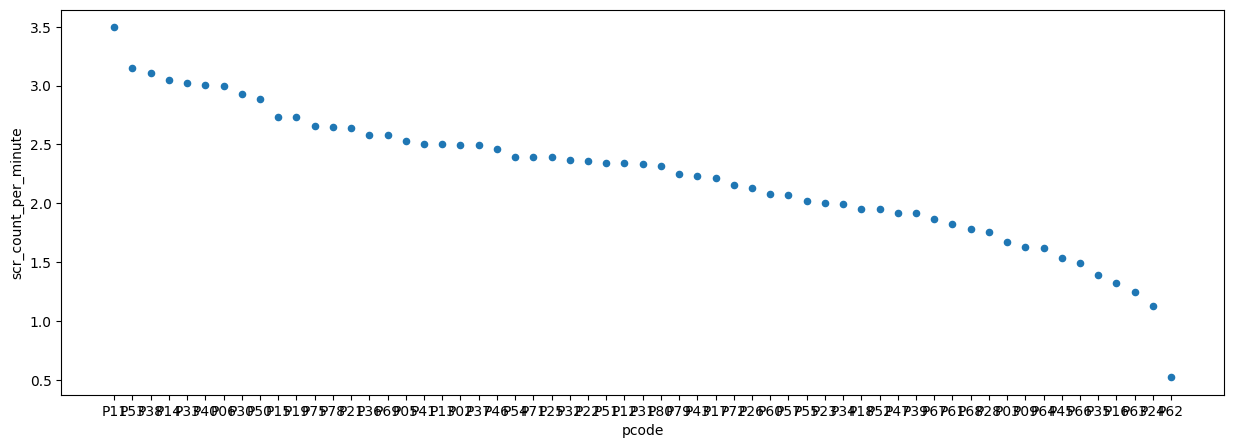

In [9]:
res.sort_values(by=measurement, ascending=False, inplace=True)
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))

In [10]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


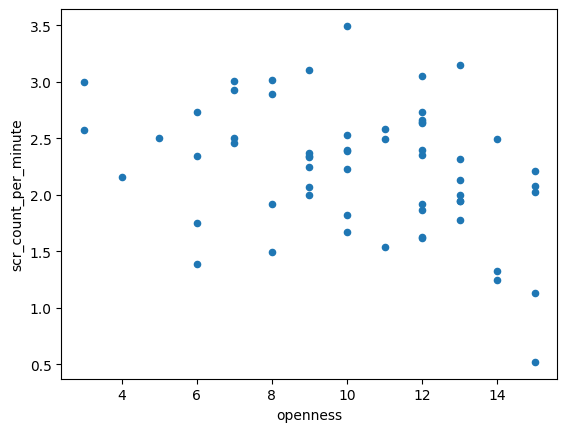

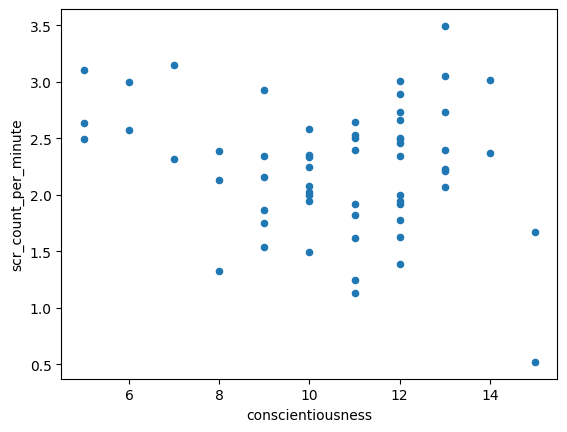

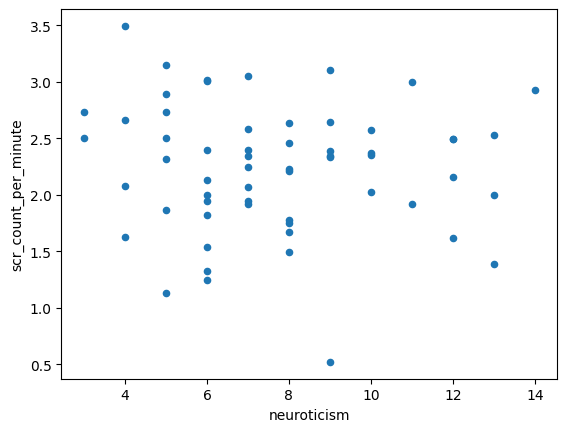

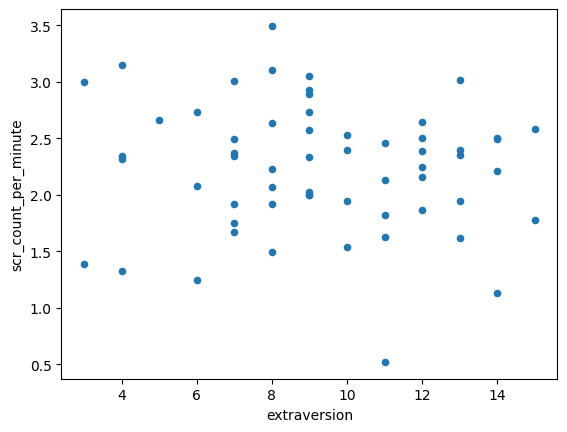

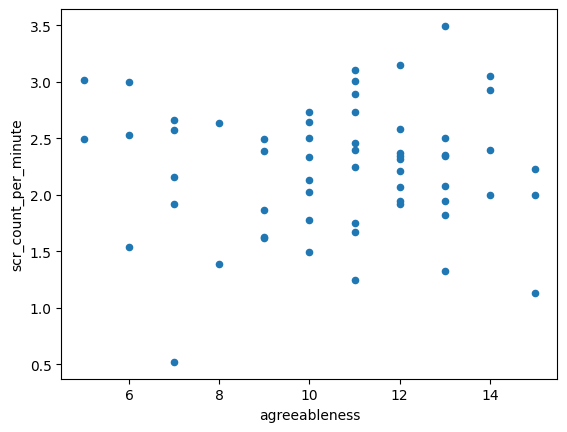

In [11]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [12]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                             OLS Regression Results                             
Dep. Variable:     scr_count_per_minute   R-squared:                       0.185
Model:                              OLS   Adj. R-squared:                  0.108
Method:                   Least Squares   F-statistic:                     2.405
Date:                  Sun, 02 Jun 2024   Prob (F-statistic):             0.0487
Time:                          16:30:55   Log-Likelihood:                -43.412
No. Observations:                    59   AIC:                             98.82
Df Residuals:                        53   BIC:                             111.3
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

ShapiroResult(statistic=0.9846863947102241, pvalue=0.6642048002771)

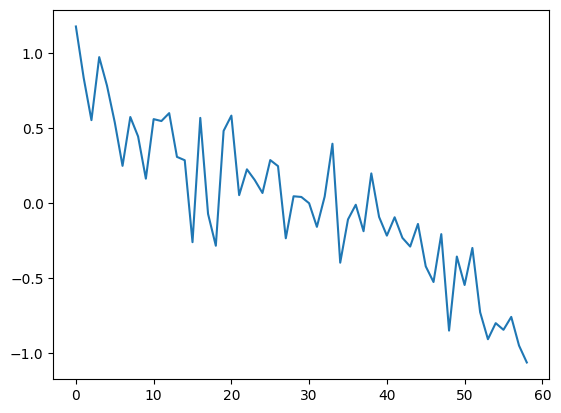

In [13]:
plt.plot(results.resid)
scipy.stats.shapiro(results.resid)

In [14]:
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=-0.3460231508248024, pvalue=0.0072646403321263665)
conscientiousness PearsonRResult(statistic=-0.1800569309690409, pvalue=0.17236794986987242)
neuroticism PearsonRResult(statistic=-0.0630621494233785, pvalue=0.6351446347978573)
extraversion PearsonRResult(statistic=-0.08658735685982547, pvalue=0.5143455907477796)
agreeableness PearsonRResult(statistic=0.0121997567671919, pvalue=0.9269312391730353)
